In [1]:
#Imports

import os
import time
import tqdm
import numpy as np
import qcodes as qc
from qcodes.utils.dataset.doNd import do1d, do2d, dond, plot, LinSweep, LogSweep
from qcodes.dataset.descriptions.detect_shapes import detect_shape_of_measurement
from qcodes.tests.instrument_mocks import DummyInstrument, DummyInstrumentWithMeasurement


from qcodes.dataset import (
    load_or_create_experiment,
    load_by_guid,
    load_by_run_spec,
    initialise_or_create_database_at,
    Measurement,
    DataSetType,
)
from qcodes.tests.instrument_mocks import (
    DummyInstrument,
    DummyInstrumentWithMeasurement,
)
from qcodes.dataset.plotting import plot_dataset


Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\a-davidpoole\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\a-davidpoole\.qcodes\logs\211115-1704-qcodes.log


In [2]:
#Set up local database

testing_db_path = os.path.join(os.getcwd(), 'local.db')
initialise_or_create_database_at(testing_db_path)

In [3]:

# preparatory mocking of physical setup
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)


In [4]:

# Setting up Measurement
testing_exp = load_or_create_experiment('loop_1', sample_name='no sample')

#Setting up measuremetn without shape
meas = Measurement(name= 'simple meas', exp=testing_exp)
meas.register_parameter(dac.ch1)
meas.register_parameter(dac.ch2)
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,dac.ch2))
meas.register_parameter(dmm.v2, setpoints=(dac.ch1,dac.ch2))

#Setting Up measurement with shapes
meas_with_shape = Measurement(exp=testing_exp, name='shape meas')
meas_with_shape.register_parameter(dac.ch1)  # register the first independent parameter
meas_with_shape.register_parameter(dac.ch2)  # register the second independent parameter
meas_with_shape.register_parameter(dmm.v1, setpoints=(dac.ch1, dac.ch2))  # now register the dependent oone
meas_with_shape.register_parameter(dmm.v2, setpoints=(dac.ch1, dac.ch2))  # now register the dependent oone



In [5]:
#Setting up dataset sizes.
size_a = 500
size_b = 200
size_n = 1

In [6]:
#Measurement with context manager with cache
t_a = []

bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)

for _ in range(size_n):
    with meas.run() as datasaver:
        for dac1_sweep in np.linspace(-1, 1, size_a): # sweep points over channel 1
            dac.ch1(dac1_sweep)
            t = []
            for dac2_sweep in np.linspace(-1, 1, size_b): # sweep points over channel 2
                dac.ch2(dac2_sweep)
                t0 = time.perf_counter()
                datasaver.add_result(
                    (dac.ch1, dac.ch1()),
                    (dac.ch2, dac.ch2()),
                    (dmm.v1, dmm.v1()),
                    (dmm.v2, dmm.v2())
                    )
                t1 = time.perf_counter()
                t.append(t1-t0)
                bar.update(1)
            t_a.append(sum(t)/len(t)*1000)
        dataset2 = datasaver.dataset

print(sum(t_a)/len(t_a))

2021-11-15 18:56:44,721 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 109 ¦ C:\Users\A-DAVI~1\AppData\Local\Temp/ipykernel_1704/616408506.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)



  0%|          | 0/100000 [00:00<?, ?it/s]

Starting experimental run with id: 7. 
0.7725711649999891


In [7]:
#Measurement with context manager with shaped cache
meas_with_shape.set_shapes(detect_shape_of_measurement((dmm.v1,dmm.v2), (size_a, size_b)))

bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)

t_b = []
for _ in range(size_n):
    with meas_with_shape.run() as datasaver:
        for dac1_sweep in np.linspace(-1, 1, size_a): 
            dac.ch1(dac1_sweep)
            t = []
            for dac2_sweep in np.linspace(-1, 1, size_b):
                dac.ch2(dac2_sweep)
                t0 = time.perf_counter()
                datasaver.add_result(
                    (dac.ch1, dac.ch1()),
                    (dac.ch2, dac.ch2()),
                    (dmm.v1, dmm.v1()),
                    (dmm.v2, dmm.v2())
                    )
                t1 = time.perf_counter()
                t.append(t1-t0)
                bar.update(1)
            t_b.append(sum(t)/len(t)*1000)
        dataset2 = datasaver.dataset
print(sum(t_b)/len(t_b))


2021-11-15 18:58:07,143 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 109 ¦ C:\Users\A-DAVI~1\AppData\Local\Temp/ipykernel_1704/2853598699.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)



  0%|          | 0/100000 [00:00<?, ?it/s]

Starting experimental run with id: 8. 
0.22837625199998926


In [8]:
#Measurement with context manager without cache
t_c = []
bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)

for _ in range(size_n):
    with meas.run(in_memory_cache=False) as datasaver:
        for dac1_sweep in np.linspace(-1, 1, size_a): 
            dac.ch1(dac1_sweep)
            t = []
            for dac2_sweep in np.linspace(-1, 1, size_b):
                dac.ch2(dac2_sweep)
                #bar.update(1)
                t0 = time.perf_counter()
                datasaver.add_result(
                    (dac.ch1, dac.ch1()),
                    (dac.ch2, dac.ch2()),
                    (dmm.v1, dmm.v1()),
                    (dmm.v2, dmm.v2())
                    )
                t1 = time.perf_counter()
                t.append(t1-t0)
                bar.update(1)
            t_c.append(sum(t)/len(t)*1000)
        dataset2 = datasaver.dataset

print(sum(t_c)/len(t_c))

2021-11-15 18:58:33,123 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 109 ¦ C:\Users\A-DAVI~1\AppData\Local\Temp/ipykernel_1704/2863477060.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)



  0%|          | 0/100000 [00:00<?, ?it/s]

Starting experimental run with id: 9. 
0.1254850570000386


In [9]:
#Measurement with context manager with cache, dataset in memory.
t_d = []
bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)

for _ in range(size_n):
    with meas.run(dataset_class=DataSetType.DataSetInMem) as datasaver:
        for dac1_sweep in np.linspace(-1, 1, size_a): 
            dac.ch1(dac1_sweep)
            t = []
            for dac2_sweep in np.linspace(-1, 1, size_b): 
                dac.ch2(dac2_sweep)
                #bar.update(1)
                t0 = time.perf_counter()
                datasaver.add_result(
                    (dac.ch1, dac.ch1()),
                    (dac.ch2, dac.ch2()),
                    (dmm.v1, dmm.v1()),
                    (dmm.v2, dmm.v2())
                    )
                t1 = time.perf_counter()
                t.append(t1-t0)
                bar.update(1)
            t_d.append(sum(t)/len(t)*1000)
        dataset2 = datasaver.dataset
print(sum(t_d)/len(t_d))

2021-11-15 18:58:48,206 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 109 ¦ C:\Users\A-DAVI~1\AppData\Local\Temp/ipykernel_1704/1923311262.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)



  0%|          | 0/100000 [00:00<?, ?it/s]

Starting experimental run with id: 10. 
0.4090112040000139


In [10]:
#Measurement with context manager with shaped cache and dataset in memory
meas_with_shape.set_shapes(detect_shape_of_measurement((dmm.v1,dmm.v2), (size_a, size_b)))

t_e = []
bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)

for _ in range(size_n):
    with meas_with_shape.run(dataset_class=DataSetType.DataSetInMem) as datasaver:
        for dac1_sweep in np.linspace(-1, 1, size_a): 
            dac.ch1(dac1_sweep)
            t = []
            for dac2_sweep in np.linspace(-1, 1, size_b):
                dac.ch2(dac2_sweep)
                t0 = time.perf_counter()
                datasaver.add_result(
                    (dac.ch1, dac.ch1()),
                    (dac.ch2, dac.ch2()),
                    (dmm.v1, dmm.v1()),
                    (dmm.v2, dmm.v2())
                    )
                t1 = time.perf_counter()
                t.append(t1-t0)
                bar.update(1)
            t_e.append(sum(t)/len(t)*1000)
        dataset2 = datasaver.dataset
print(sum(t_e)/len(t_e))

2021-11-15 18:59:32,651 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 109 ¦ C:\Users\A-DAVI~1\AppData\Local\Temp/ipykernel_1704/1493501015.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)



  0%|          | 0/100000 [00:00<?, ?it/s]

Starting experimental run with id: 11. 
0.17479894299996857


In [11]:
#Measurement with doNd, estimated time by total dataset size
#Bar is not included since this may add a slight delay.
sweep_1 = LinSweep(dac.ch1, -1, 1, size_a)
sweep_2 = LinSweep(dac.ch2, -1, 1, size_b)
t_f = []
for _ in range(size_n):
    t0 = time.perf_counter()
    dond(sweep_1, sweep_2, dmm.v1, dmm.v2, exp=testing_exp) 
    t1 = time.perf_counter()
    t_f.append(t1-t0)
print(sum(t_f)/len(t_f)/size_a/size_b*1000)   

Starting experimental run with id: 12. Using 'qcodes.utils.dataset.doNd.dond'
0.210344111


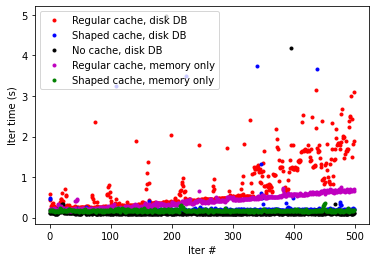

In [12]:
#plotting the measurement context results in a single figure.
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

plt.plot(t_a, '.r', label='Regular cache, disk DB') 
plt.plot(t_b, '.b', label='Shaped cache, disk DB')
plt.plot(t_c, '.k', label='No cache, disk DB')
plt.plot(t_d, '.m', label='Regular cache, memory only')
plt.plot(t_e, '.g', label='Shaped cache, memory only')
#plt.ylim(0,0.01)
plt.ylabel('Iter time (s)') 
plt.xlabel('Iter #') 
plt.legend()
plt.show() 

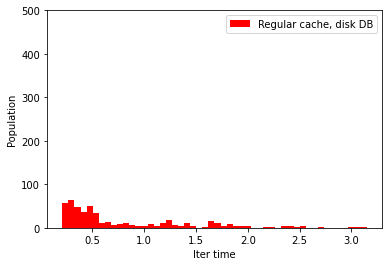

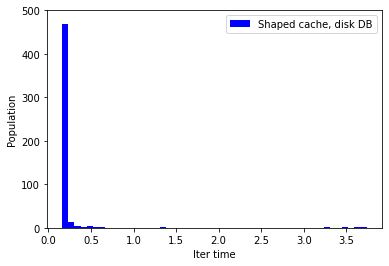

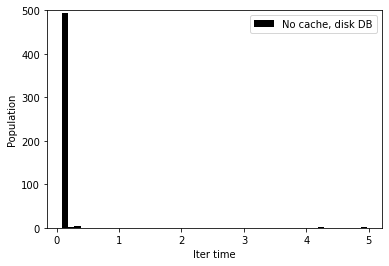

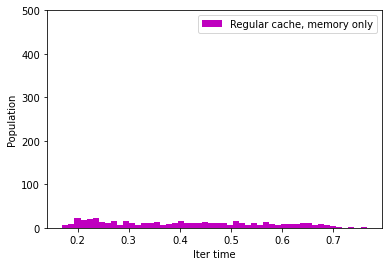

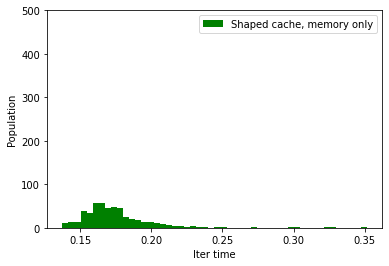

In [15]:
#plotting the measurement context results as a histogram.
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

plt.hist(t_a, 50, facecolor= 'r', label='Regular cache, disk DB') 
plt.ylabel('Population')
plt.ylim(0, size_a)
plt.xlabel('Iter time') 
plt.legend()
plt.show() 
plt.hist(t_b, 50, facecolor= 'b', label='Shaped cache, disk DB')
plt.ylabel('Population')
plt.ylim(0, size_a)
plt.xlabel('Iter time') 
plt.legend()
plt.show() 
plt.hist(t_c, 50, facecolor= 'k', label='No cache, disk DB')
plt.ylabel('Population')
plt.ylim(0, size_a)
plt.xlabel('Iter time') 
plt.legend()
plt.show() 
plt.hist(t_d, 50, facecolor= 'm', label='Regular cache, memory only')
plt.ylabel('Population')
plt.ylim(0, size_a)
plt.xlabel('Iter time') 
plt.legend()
plt.show() 
plt.hist(t_e, 50, facecolor= 'g', label='Shaped cache, memory only')
plt.ylabel('Population')
plt.ylim(0, size_a)
plt.xlabel('Iter time') 
plt.legend()
plt.show() 